In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ephem
from datetime import datetime
import math

In [366]:
#!pip install gymnasium
#!pip install stable-baselines3[extra]

In [367]:
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C,DQN,PPO
from stable_baselines3.common.env_util import make_vec_env

import torch
import torch.nn as nn

import os

In [368]:
train = pd.read_csv('Useful data/train_final.csv')
ctrl = pd.read_csv('Useful data/ctrl_final.csv')

In [369]:
print(train.columns)


Index(['Date', 'Time', 'T - Inlet gap for door - Test Dept.', 'RH - Inlet gap for door - Test Dept.', 'T - Inlet gap outside wall - Test Dept.', 'RH - Inlet gap outside wall - Test Dept.', 'T - Enclosure front compartment - Test Dept.', 'RH - Enclosure front compartment - Test Dept.', 'T - Enclosure rear compartment - Test Dept.', 'RH - Enclosure rear compartment - Test Dept.', 'T - Macro front compartment - Test Dept.', 'RH - Macro front compartment - Test Dept.', 'T - Macro rear compartment - Test Dept.', 'RH - Macro rear compartment - Test Dept.', 'T - Drainage chute - Test Dept.', 'RH - Drainage chute - Test Dept.', 'Round', 'T- Outside at air inlet', 'RH- Outside at air inlet', 'T- Inlet for conditioner', 'RH- Inlet for conditioner', 'T- Inlet behind conditioner', 'RH- Inlet behind conditioner', 'Temperature setting', 'Current temperature', 'Bandwidth', 'Current ventilation', 'Calculated ventilation', 'Minimum ventilation', 'Maximum ventilation', 'Outside temperature'], dtype='obj

In [370]:
train['humidity'] = (train['RH - Macro front compartment - Test Dept.'] + train['RH - Macro rear compartment - Test Dept.'])/2
ctrl['humidity'] = (ctrl['RH - Macro front compartment - Control Dept.'] + ctrl['RH - Macro rear compartment - Control Dept.'])/2

In [371]:
train = train.loc[:, ['Date', 'Time', 'Round', 'T - Drainage chute - Test Dept.', 'T- Outside at air inlet', 'T- Inlet behind conditioner','T - Inlet gap for door - Test Dept.', 'T - Inlet gap outside wall - Test Dept.', 'T- Inlet for conditioner','T - Macro front compartment - Test Dept.', 'T - Macro rear compartment - Test Dept.','T- Inlet behind conditioner', 'Current temperature', 'Bandwidth', 'Current ventilation', 'Minimum ventilation', 'Maximum ventilation', 'Outside temperature', 'humidity','Temperature setting']]
ctrl = ctrl.loc[:, ['Date', 'Time', 'Round', 'T - Drainage chute - Control Dept.', 'T- Outside at air inlet', 'T- Inlet behind conditioner','T - Inlet gap for door - Control Dept.', 'T - Inlet gap outside wall - Control Dept.', 'T- Inlet for conditioner','T - Macro front compartment - Control Dept.', 'T - Macro rear compartment - Control Dept.','T- Inlet behind conditioner', 'Current temperature', 'Bandwidth', 'Current ventilation', 'Minimum ventilation', 'Maximum ventilation', 'Outside temperature', 'humidity', 'Temperature setting']]

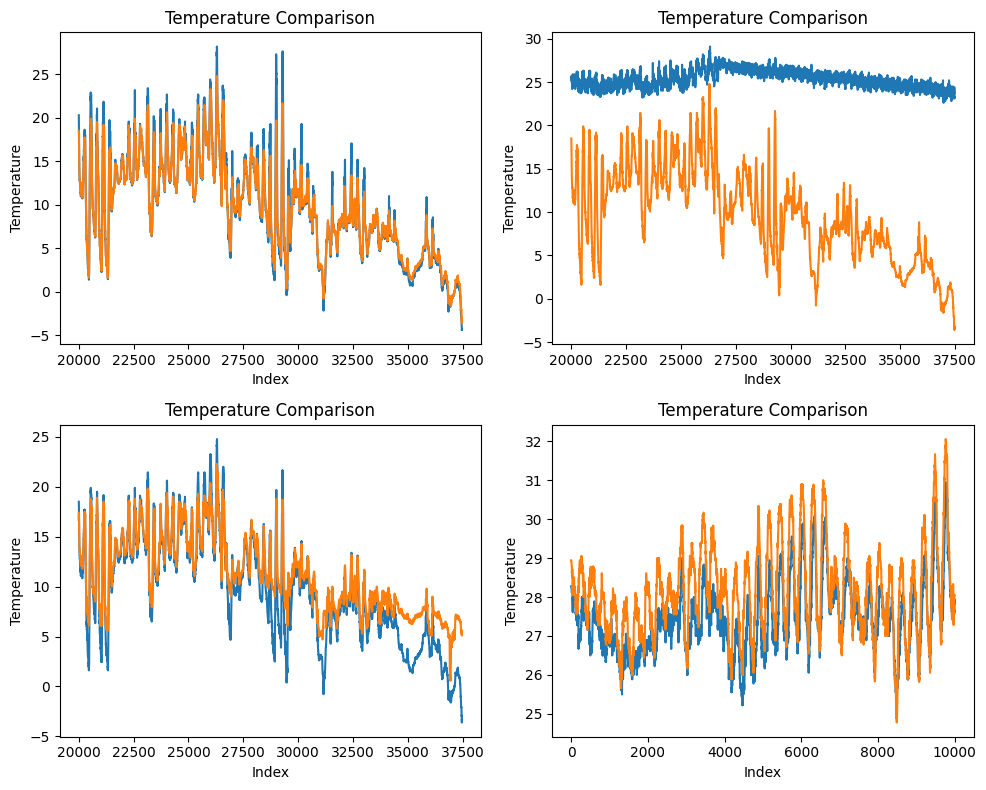

In [372]:
import matplotlib.pyplot as plt
train1 = train.iloc[20000:50000]
train2 = train.iloc[0:10000]

# Create a figure and axes for the gridfig, 
fg, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot the first plot in the top-left position
axes[0][0].plot(train1['T- Outside at air inlet'], label='T- Inlet for conditioner')
axes[0][0].plot(train1['T- Inlet for conditioner'], label='T- Inlet for conditioner')
axes[0][0].set_xlabel('Index')
axes[0][0].set_ylabel('Temperature')
axes[0][0].set_title('Temperature Comparison')

axes[1][0].plot(train1['T- Inlet for conditioner'], label='T- Inlet for conditioner')
axes[1][0].plot(train1['Outside temperature'], label='T- Inlet behind conditioner')
axes[1][0].set_xlabel('Index')
axes[1][0].set_ylabel('Temperature')
axes[1][0].set_title('Temperature Comparison')


# Plot the second plot in the top-right position
axes[0][1].plot(train1['Current temperature'], label='Current temperature')
axes[0][1].plot(train1['T- Inlet for conditioner'], label='Current temperature')
axes[0][1].set_xlabel('Index')
axes[0][1].set_ylabel('Temperature')
axes[0][1].set_title('Temperature Comparison')

# Plot the second plot in the top-right position
axes[1][1].plot(train2['T - Macro front compartment - Test Dept.'], label='Current temperature')
axes[1][1].plot(train2['T - Macro rear compartment - Test Dept.'], label='Current temperature')
axes[1][1].set_xlabel('Index')
axes[1][1].set_ylabel('Temperature')
axes[1][1].set_title('Temperature Comparison')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


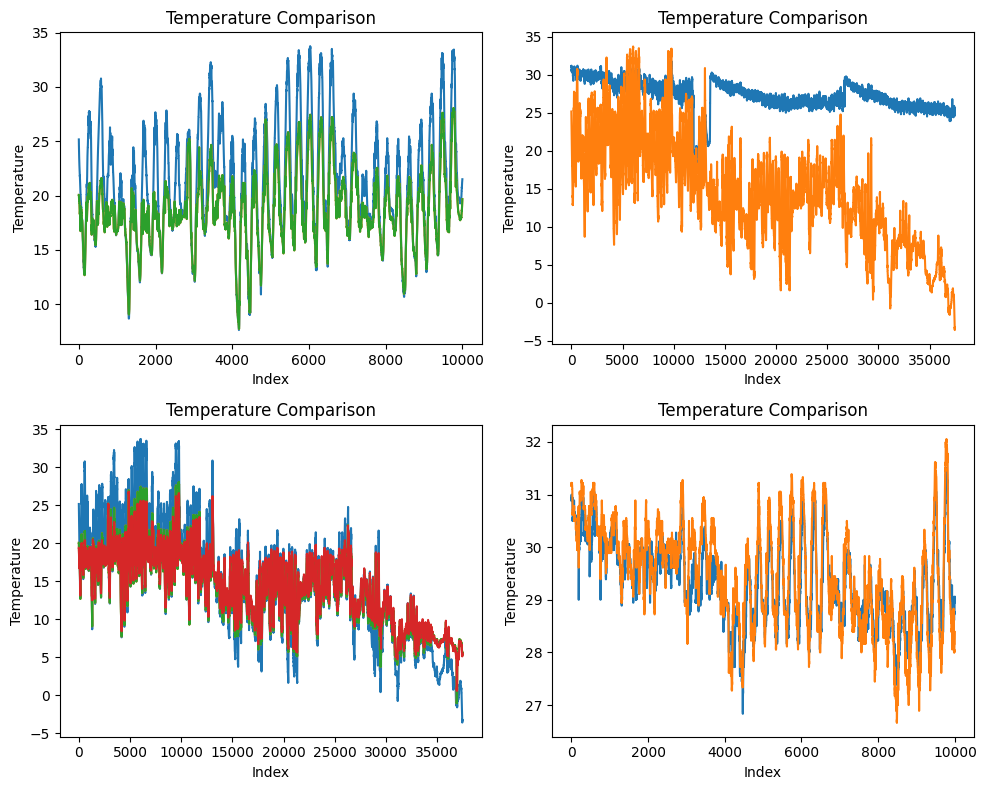

In [373]:
import matplotlib.pyplot as plt
ctrl1 = ctrl.iloc[0000:40000]
ctrl2 = ctrl.iloc[0:10000]

# Create a figure and axes for the gridfig, 
fg, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axes[0][0].plot(ctrl2['T- Inlet for conditioner'], label='T- Inlet for conditioner')
axes[0][0].plot(ctrl2['T- Inlet behind conditioner'], label='T- Inlet for conditioner')
axes[0][0].set_xlabel('Index')
axes[0][0].set_ylabel('Temperature')
axes[0][0].set_title('Temperature Comparison')

axes[1][0].plot(ctrl1['T- Inlet for conditioner'], label='T- Inlet for conditioner')
axes[1][0].plot(ctrl1['T- Inlet behind conditioner'], label='T- Inlet behind conditioner')
axes[1][0].plot(ctrl1['Outside temperature'], label='T- Inlet behind conditioner')
axes[1][0].set_xlabel('Index')
axes[1][0].set_ylabel('Temperature')
axes[1][0].set_title('Temperature Comparison')

axes[0][1].plot(ctrl1['Current temperature'], label='Current temperature')
axes[0][1].plot(ctrl1['T- Inlet for conditioner'], label='Current temperature')
axes[0][1].set_xlabel('Index')
axes[0][1].set_ylabel('Temperature')
axes[0][1].set_title('Temperature Comparison')

axes[1][1].plot(ctrl2['T - Macro front compartment - Control Dept.'], label='Current temperature')
axes[1][1].plot(ctrl2['T - Macro rear compartment - Control Dept.'], label='Current temperature')
axes[1][1].set_xlabel('Index')
axes[1][1].set_ylabel('Temperature')
axes[1][1].set_title('Temperature Comparison')

plt.tight_layout()


In [374]:
train23 = train[train['Round'].isin([2,3])]

# Estimating parameters for the balance equation

## $\text{Balance equation:} \frac{\partial T_i}{{\partial t}} = \frac{1}{C} * (Q_{\text{gain}} - Q_{loss})$

$\frac{\partial T_i}{{\partial t}}$ is the rate of temperature change (°C/s or °C/min).

C is the thermal capacitance of the pig house (expressed in J/°C or J/K). $C = c_p \cdot m$, where $c_p$ is the specfic heat capacity of the air in the envelope and $m$ is the mass of Air in the building. $m$ can be espressed as $V \cdot \rho_a$ where $V$ is the volume of the building and $\rho_a$ is the air density.

$Q_{\text{gain}}$ represents the total heat input into the pig house from various sources (Heat gain form pigs, floor heating system, heating exchanger, solar radiation)

$Q_{\text{loss}}$ represents the total heat loss from the pig house (ventilation system, building envelope).

This leads to the equation:

### $\rho_a \cdot V \cdot c_p \frac{\partial T_i}{{\partial t}} = Q_h + Q_{fh} + Q_r + Q_p + Q_v + Q_e$

 $T_{i+1} = T_i + \frac{\partial T_i}{{\partial t}} = T_i + \frac{Q_h + Q_{fh} + Q_r + Q_p + Q_v + Q_e}{\rho_a \cdot V \cdot c_p}$


## 1. first half of the equation

## Air density

The air density $\rho$ can be calculated using the following function:

\begin{equation}
\rho = \frac{{P_{\text{dry\_air}}}}{{R_{\text{dry\_air}} \times T}}
\end{equation}

where:
\begin{align*}
R_{\text{dry\_air}} &= 287.05 \, \text{J/kg K} \\
P_{\text{atm}} &= 101325 \, \text{Pa}
\end{align*}

The vapor pressure of water vapor $e$ is calculated using:

\begin{equation}
e = 6.112 \times \exp\left(\frac{{17.67 \times T_i}}{{T_i + 243.5}}\right)
\end{equation}

The partial pressure of dry air $P_{\text{dry\_air}}$ can be obtained as:

\begin{equation}
P_{\text{dry\_air}} = P_{\text{atm}} - e
\end{equation}

Finally, substituting $P_{\text{dry\_air}}$ and $T$ into Equation (1), we get:

\begin{equation}
\rho = \frac{{P_{\text{atm}} - e}}{{R_{\text{dry\_air}} \times (T_i + 273.15)}}
\end{equation}


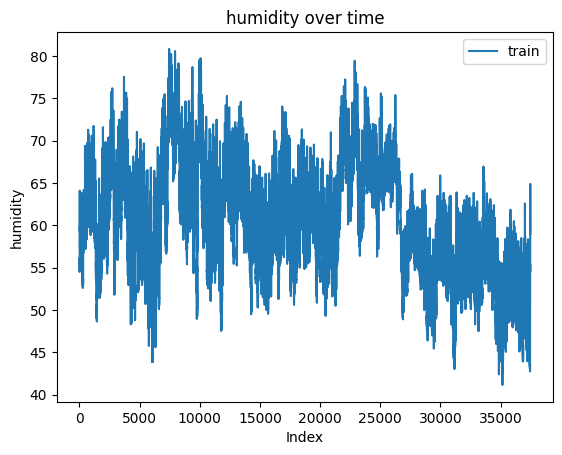

In [375]:
plt.plot(train['humidity'], label='train')
plt.xlabel('Index')
plt.ylabel('humidity')
plt.title('humidity over time')
plt.legend()
plt.show()

## Air specific heat capacity

$C_{pa} = f_d \times C_{pd} + f_v \times C_{pv}$

$C_{pa}$: Specific heat capacity of moist air (J/(kg·K)). 

$f_d$: Fraction of dry air in the air mixture 

$C_{pd}$: Specific heat capacity of dry air at constant pressure (J/(kg·K)). It represents the amount of heat required to raise the temperature of dry air by one degree Celsius at constant pressure. 

$f_v$: Fraction of water vapor in the air mixture. It represents the proportion of water vapor in the total air mixture. 

$C_{pv}$: Specific heat capacity of water vapor at constant pressure (J/(kg·K)). 


## Volume $9.69 \cdot 31 \cdot 3 = 901.17 m^3$

# 2. $Q_r$: heat gain in unit time from Solar radiation

## Solar irradiance

$I = I_0 * \cos{\theta}$

$I$: Solar irradiance on a flat surface (semplification, do not know the shape of the roof)

$I_o$: The average solar irradiance outside Earth's atmosphere, approximately 1361 W/m^2

$\theta$: Solar zenith angle, the angle between the Sun and the vertical direction. Can be estimated using the latitude and the time of the day :D

Since I do not know the latitdue of the farm I will use the central latitude and longitude of the netherlands for now (52.1326 and 5.2913).
When the cosine of theta is negative (night time) it is set to 0 so solar radiation is approximately 0.

In [376]:
train['Date'] = pd.to_datetime(train['Date'])
train['Time'] = pd.to_datetime(train['Time'])
train['Time'] = train['Time'].dt.time

ctrl['Date'] = pd.to_datetime(ctrl['Date'])
ctrl['Time'] = pd.to_datetime(ctrl['Time'])
ctrl['Time'] = ctrl['Time'].dt.time

C:\Users\aleza\AppData\Local\Temp\ipykernel_10376\3959224451.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Time'] = pd.to_datetime(train['Time'])
C:\Users\aleza\AppData\Local\Temp\ipykernel_10376\3959224451.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ctrl['Time'] = pd.to_datetime(ctrl['Time'])


In [377]:
Radiation_data = pd.read_csv('C:/Users/aleza/Desktop/University/Master thesis/Data and documentation abiìout data/Radiation files/Radiation_dataset.csv')

In [378]:
Radiation_data['Date'] = pd.to_datetime(Radiation_data['DTG'])
Radiation_data['Time'] = pd.to_datetime(Radiation_data['LOCATION'], format='%H:%M:%S').dt.time

Radiation_data = Radiation_data.drop(['DTG', 'LOCATION'], axis=1)


def fill_missing_times(df, date_col, time_col, time_freq='10T'):

    df[date_col] = df[date_col].astype(str)
    df[time_col] = df[time_col].astype(str)

    # Combine date and time columns into a single datetime column
    df['datetime'] = pd.to_datetime(df[date_col] + ' ' + df[time_col])

    # Create a complete datetime range from the min to max datetime in the dataframe
    full_datetime_range = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq=time_freq)

    # Reindex the DataFrame to include all datetimes in the full_datetime_range
    df = df.set_index('datetime').reindex(full_datetime_range).reset_index()

    # Rename the index column back to 'datetime'
    df = df.rename(columns={'index': 'datetime'})

    # Split the datetime back into separate date and time columns
    df[date_col] = df['datetime'].dt.date
    df[time_col] = df['datetime'].dt.time

    # Drop the temporary datetime column
    df = df.drop(columns=['datetime'])

    return df

# Assuming your DataFrame is named 'df' and has columns 'Date' and 'Time':
Radiation_data = fill_missing_times(Radiation_data, date_col='Date', time_col='Time')



Radiation_data['Q_GLOB_10'].fillna((Radiation_data['Q_GLOB_10'].shift() + Radiation_data['Q_GLOB_10'].shift(-1)) / 2, inplace=True)

In [379]:
train['Date'] = pd.to_datetime(train['Date'])
train['Time'] = train['Time'].astype(str)

ctrl['Date'] = pd.to_datetime(ctrl['Date'])
ctrl['Time'] = ctrl['Time'].astype(str)

Radiation_data['Date'] = pd.to_datetime(Radiation_data['Date'])
Radiation_data['Time'] = Radiation_data['Time'].astype(str)

In [380]:
# Ensure that both DataFrames have the same data types for the 'Date' and 'Time' columns
train = pd.merge(train, Radiation_data, on=['Date', 'Time'], how='left')
ctrl = pd.merge(ctrl, Radiation_data, on=['Date', 'Time'], how='left')

In [381]:
train = train.drop(['NAME', 'LATITUDE','LONGITUDE','ALTITUDE','QN_GLOB_10','QX_GLOB_10','SQ_10'], axis=1)
ctrl = ctrl.drop(['NAME', 'LATITUDE','LONGITUDE','ALTITUDE','QN_GLOB_10','QX_GLOB_10','SQ_10'], axis=1)

In [382]:
train['Time'] = pd.to_datetime(train['Time'], format='%H:%M:%S').dt.time
ctrl['Time'] = pd.to_datetime(ctrl['Time'], format='%H:%M:%S').dt.time
for i in range(1, len(train)):
    if ((train.loc[i, 'Time'].minute % 10) != 0):
        train.loc[i, 'Q_GLOB_10'] = train.loc[i-1, 'Q_GLOB_10']

for i in range(1, len(ctrl)):
    if ((ctrl.loc[i, 'Time'].minute % 10) != 0):
        ctrl.loc[i, 'Q_GLOB_10'] = ctrl.loc[i-1, 'Q_GLOB_10']      

In [383]:
import pandas as pd

def fill_missing_with_previous_day(df, date_col, time_col, value_col):
    
    df[date_col] = pd.to_datetime(df[date_col])
    df[time_col] = df[time_col].astype(str)

    # Sort the DataFrame by date and time
    df = df.sort_values(by=[date_col, time_col])

    # Shift the value column by 1 day (24 hours)
    df['previous_day_value'] = df.groupby(time_col)[value_col].shift(1)

    # Fill NaN values in the original column with the shifted values
    df[value_col].fillna(df['previous_day_value'], inplace=True)

    # Drop the temporary 'previous_day_value' column
    df = df.drop(columns=['previous_day_value'])

    return df

train = fill_missing_with_previous_day(train, date_col='Date', time_col='Time', value_col='Q_GLOB_10')
ctrl = fill_missing_with_previous_day(ctrl, date_col='Date', time_col='Time', value_col='Q_GLOB_10')


train_id = train['Q_GLOB_10']
ctrl_id = ctrl['Q_GLOB_10']  

## envelope surface of pig building that received solar radiation

In [384]:
import datetime
import pytz
import pandas as pd
import numpy as np
import pysolar.solar as solar

def calculate_parallelepiped_surface_area(latitude, longitude, date, time, length, width, height):
    datetime_combined = datetime.datetime.combine(date, datetime.datetime.min.time()) + time
    
    # Make datetime object timezone-aware
    timezone = pytz.timezone('UTC')
    datetime_combined = timezone.localize(datetime_combined)
    
    # Calculate solar altitude and azimuth angles
    altitude = solar.get_altitude(latitude, longitude, datetime_combined)
    azimuth = solar.get_azimuth(latitude, longitude, datetime_combined)
    
    # Determine the face of the parallelepiped exposed to the sun based on the solar angles
    if altitude > 0:
        if 0 <= azimuth < 90 or 270 <= azimuth < 360:
            surface_area_exposed = width * height
        elif 90 <= azimuth < 270:
            surface_area_exposed = length * height
    else:
        surface_area_exposed = 0
    
    return surface_area_exposed

train_date = pd.to_datetime(train['Date'])

train_time = pd.to_timedelta(train['Time'].astype(str))

latitude = 52.1326
longitude = 5.2913

In [385]:
import math
import pysolar.solar as solar
import pytz
from datetime import datetime, timedelta, time

def building_surface_area(latitude, longitude, length, width, height, date, time):
    """
    Estimate the surface area of a building hit by solar radiation.

    Parameters:
    - latitude: Latitude of the building (degrees)
    - longitude: Longitude of the building (degrees)
    - length: Length of the building (meters)
    - width: Width of the building (meters)
    - height: Height of the building (meters)
    - date: Date for estimation (datetime.date object)
    - time: Time for estimation (datetime.time object)

    Returns:
    - surface_area: Estimated surface area hit by solar radiation (square meters)
    """

    # Combine date and time into a single datetime object
    date_time = datetime.combine(date, time, tzinfo=pytz.utc)

    # Calculate solar position
    altitude = solar.get_altitude(latitude, longitude, date_time)

    # Check if the sun is below the horizon
    if altitude <= 0:
        return 0  # Return 0 surface area when the sun is below the horizon

    # Convert altitude to radians
    altitude_rad = math.radians(altitude)

    # Calculate the surface area facing the sun
    # For simplicity, we assume the building is a rectangular prism
    # The surface area facing the sun is the product of the height and the projection of the base
    # projection of base = length * cos(altitude) + width * sin(altitude)
    projection_of_base = length * math.cos(altitude_rad) + width * math.sin(altitude_rad)
    
    # Surface area facing the sun = height * projection of base
    surface_area = height * projection_of_base

    return surface_area if surface_area > 0 else 0


latitude = 52.1326
longitude = 5.2913
length = 31 
width = 9.5 
height = 3

train_date = pd.to_datetime(train['Date'])
train_time = pd.to_timedelta(train['Time'].astype(str))
train['date_time'] = train_date + train_time

# Apply the function to the DataFrame
train_areahit1 = train['date_time'].apply(lambda x: building_surface_area(latitude, longitude, length, width, height, x.date(), x.time()))

train['Id_areahit'] = train_id*train_areahit1


ctrl_date = pd.to_datetime(ctrl['Date'])
ctrl_time = pd.to_timedelta(ctrl['Time'].astype(str))
ctrl['date_time'] = ctrl_date + ctrl_time

# Apply the function to the DataFrame
ctrl_areahit1 = ctrl['date_time'].apply(lambda x: building_surface_area(latitude, longitude, length, width, height, x.date(), x.time()))

ctrl['Id_areahit'] = ctrl_id*ctrl_areahit1

In [386]:
train['Time'] = pd.to_datetime(train['Time']).dt.time
train['hour'] = train['Time'].apply(lambda x: x.hour)
train['id'] = train_id
train['areahit'] = train_areahit1

ctrl['Time'] = pd.to_datetime(ctrl['Time']).dt.time
ctrl['hour'] = ctrl['Time'].apply(lambda x: x.hour)

C:\Users\aleza\AppData\Local\Temp\ipykernel_10376\3056085665.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Time'] = pd.to_datetime(train['Time']).dt.time
C:\Users\aleza\AppData\Local\Temp\ipykernel_10376\3056085665.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ctrl['Time'] = pd.to_datetime(ctrl['Time']).dt.time


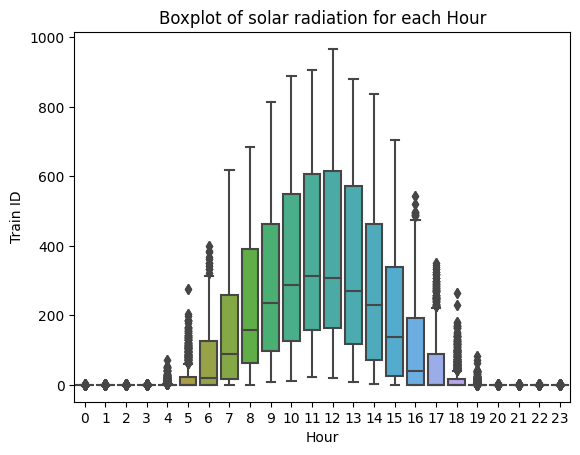

In [387]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot
sns.boxplot(x=train['hour'], y=train['id'])

# Set labels and title
plt.xlabel('Hour')
plt.ylabel('Train ID')
plt.title('Boxplot of solar radiation for each Hour')

# Show the plot
plt.show()


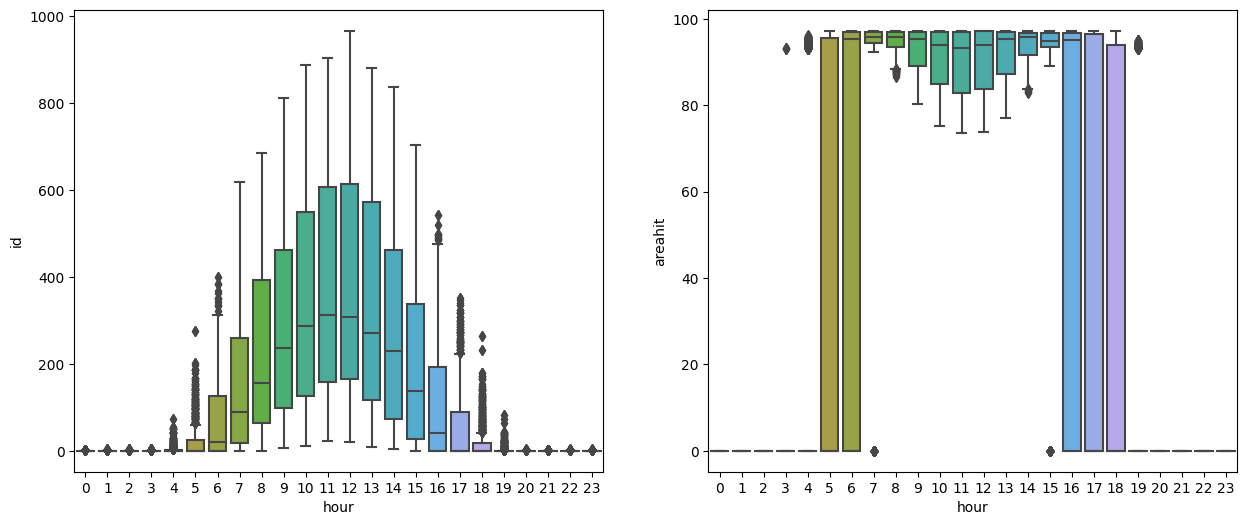

In [388]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot boxplot of 'id' against 'hour' in the left plot
sns.boxplot(x=train['hour'], y=train['id'], ax=axes[0])

# Hide the right plot
sns.boxplot(x=train['hour'], y=train['areahit'], ax=axes[1])

# Show the plot
plt.show()


In [389]:
train.to_csv('Useful data/train_final2.csv', index=False)
ctrl.to_csv('Useful data/ctrl_final2.csv', index=False)

# $Q_r$

## $Q_r = I_d \cdot A \cdot \pi_r$

where:
- $I_d = \text{Solar Radiation  } \frac{W}{m^2}$
- $A = \text{Area of the envelope surface that receives solar radiation  } m^2$
- $\pi_r = \text{envelope material transmission coefficient}$
